In [55]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d

class Sequence:
    def __init__(self):
        # (50,51) are wild jacks
        # (48,49) are anti-wild jacks
        self.deck = np.hstack((np.arange(52),np.arange(52)))

        #represent the current state of the game
        # 0 represents an empty space
        # 1 represents a space with a black token
        # -1 represents a space with a white token
        self.tokens = np.zeros((10,10))

        #randomly assign spaces on the board to cards.
        board = np.concatenate((np.random.choice(self.deck[self.deck<48],len(self.deck)-8,replace=False),
                                [-1]*4)).reshape(10,10)
        board[9,-4:-1] = [board[0,0],board[0,9],board[9,0]]
        board[0,0],board[0,9],board[9,0] = (-1,-1,-1)
        self.board = board
        
        #draw cards for players
        np.random.shuffle(self.deck)
        self.deck_pos = len(self.deck)-1
        self.hands = [self.deck[-5:],self.deck[-10:-5]]
        self.deck_pos -= 10
        self.turn = 1
    
    def play(self, play, player):
        """
        Parameters:
            play (tuple (int,(int,int)) ): play represented by card from hand and location on the board
            player (int): which player is making the move? -1 or 1
        """
        #if legal move
        
        #place or remove token
        if self.hands[(player+1)//2][play[0]] in [48,49]:
            self.tokens[play[1][0],play[1][1]] = 0
        else:
            self.tokens[play[1][0],play[1][1]] = player
        
        #draw card
        self.hands[(player+1)//2][play[0]] = self.deck[self.deck_pos]
        self.deck_pos -= 1

        #if deck is empty
            #reshuffle
        
        #change turns
        self.turn = -1*self.turn
    
    def show_board(self):
        cmap = plt.get_cmap('RdBu', 3)
        plt.matshow(self.tokens,cmap=cmap,vmin=-1,vmax=1)
        plt.colorbar(ticks=np.arange(-1,2))
        ticks = np.arange(11)-0.5
        plt.xticks(ticks)
        plt.yticks(ticks)
        plt.grid()
        plt.show()
    
    def get_moves(self,player):
        moves = list()
        j = 0
        for card in self.hands[(player+1)//2]:
            if card<48:
                locs = np.stack(np.where(np.logical_and(self.board==card,self.tokens==0))).T
            elif card < 50:
                locs = np.stack(np.where(self.tokens==(-1*player))).T
            else:
                locs = np.stack(np.where(self.tokens==0)).T
                #need to consider wild card locations
            
            for loc in locs:
                moves.append((j,loc))
            j += 1
        return moves
        
    def check_winner(self):
        kernels = [np.diag(np.ones(5)),np.flip(np.diag(np.ones(5)),axis=0),np.ones(5).reshape(5,-1),np.ones(5).reshape(-1,5)]
        for k in kernels:
            conv = convolve2d(self.tokens,k,mode='valid')
            sol = np.stack(np.where(conv==5)).T
            if len(sol) > 0:
                return 1
            sol = np.stack(np.where(conv==-5)).T
            if len(sol) > 0:
                return -1
        return 0
    
    def score_move(self,play,player):
        kernels = [np.diag(np.ones(5)),np.flip(np.diag(np.ones(5)),axis=0),np.ones(5).reshape(5,-1),np.ones(5).reshape(-1,5)]
        new_board = self.tokens.copy()
        #place or remove token
        if self.hands[(player+1)//2][play[0]] in [48,49]:
            new_board[play[1][0],play[1][1]] = 0
        else:
            new_board[play[1][0],play[1][1]] = player
        
        temp = new_board.copy()
        temp[temp==-1] = -5
        bcounts = np.zeros(4)
        for k in kernels:
            conv = convolve2d(temp,k,mode='valid')
            for i in range(4):
                bcounts[i] += (conv==(i+1)).sum()

        temp = new_board.copy()*-1
        temp[temp==-1] = -5
        wcounts = np.zeros(4)
        for k in kernels:
            conv = convolve2d(temp,k,mode='valid')
            for i in range(4):
                wcounts[i] += (conv==(i+1)).sum()
        weights = np.power(np.ones(4)*3, np.arange(4)+1)
        return (weights @ bcounts - weights @ wcounts)*player

In [129]:
game = Sequence()
i = 0
while game.check_winner()==0:
    player = (-1)**i
    moves = game.get_moves(player)
    
    if player == -1:
        scores = list()
        for move in moves:
            scores.append(game.score_move(move,player))
        game.play(moves[np.argmax(scores)],player)
    else:
        game.play(moves[np.random.randint(len(moves))],player)
    #game.show_board()
    i += 1

In [130]:
game.check_winner()

-1

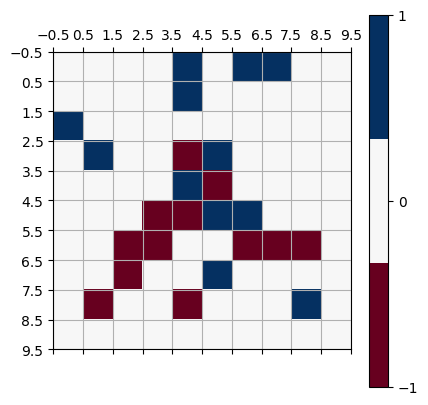

In [135]:
game.show_board()

In [133]:
data = np.array([1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1])
data = (data+1)/2
data.mean()

0.19047619047619047